In [1]:
import requests, json
import datetime
import pandas as pd
import numpy as np
from shapely.geometry import Point, LineString, Polygon

import geopandas as gp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style('whitegrid')

national_map_line_simplified = gp.read_file('national_map_line_simplified.geojson')
subzonemap = gp.read_file('singapore-residents-by-subzone-and-type-of-dwelling-jun-2017-kml.geojson')

### Extreme Points in Singapore
* North-Most Latitude : `1.4686026`
* South-Most Latitude : `1.1589744`
* West-Most Longitude : `103.6249489`
* East-Most Longitude : `104.4080556`

`ma` : max no. of alerts to return  
`mj`: max no. of jams to return  
`mu`: max no. of users to return  

`top`: North Latitude Boundary  
`bottom`: Southern Latitude Boundary  
`left`: Western Longitude Boundary  
`right`: Eastern Longitude Boundary  

In [2]:
def get_thumbs_up(comments):
    thumbs_up = 0
    for comment in comments:
        if comment['isThumbsUp']==True:
            thumbs_up += 1
    return thumbs_up

def get_thumbs_down(comments):
    thumbs_down = 0
    for comment in comments:
        if comment['isThumbsUp']==False:
            thumbs_down += 1
    return thumbs_down

In [3]:
def get_query_url(top,bottom,left,right,max_alerts,max_jams,max_users):
    url = 'https://www.waze.com/row-rtserver/web/TGeoRSS?ma={}&mj={}&mu={}&left={}&right={}&bottom={}&top={}'\
    .format(max_alerts,max_jams,max_users,left,right,bottom,top)
    return url

def get_reports(**kwargs):
    
    url = get_query_url(**kwargs)
    
    headers = {
    'Host': 'www.waze.com',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:43.0) Gecko/20100101 Firefox/43.0',
    'Accept': '*/*',
    'X-Requested-With': 'XMLHttpRequest',
    'Referer': 'https://www.waze.com/livemap',
    }
    
    response = requests.get(url, headers=headers)
    
    raw_data = response.json()
    
    alerts_df = pd.DataFrame().from_dict(raw_data['alerts'])
    jams_df = pd.DataFrame().from_dict(raw_data['jams'])
    users_df = pd.DataFrame().from_dict(raw_data['users'])
    
    alerts_df['datetime'] = pd.to_datetime(alerts_df["pubMillis"], unit='ms')
    jams_df['datetime'] = pd.to_datetime(jams_df["updateMillis"], unit='ms')
    
    alerts_df[['lon','lat']] = alerts_df["location"].apply(pd.Series)
    users_df[['lon','lat']] = users_df["location"].apply(pd.Series)
    
    alerts_df["thumbs_up"] = alerts_df["comments"].apply(get_thumbs_up)
    alerts_df["thumbs_down"] = alerts_df["comments"].apply(get_thumbs_down)
    
    alerts_df = pd.concat([alerts_df.drop(['comments'], axis=1),
                          alerts_df['comments'].apply(len)], axis=1)
    
    
    
    outp = {
        'alerts':alerts_df,
        'jams':jams_df,
        'users':users_df
    }
    
    return outp

In [4]:
reports_dict = get_reports(top=1.46,
                           bottom=1.15,
                           left=103.62,
                           right=104.4,
                           max_alerts=200,
                           max_jams=200,
                           max_users=1)

In [5]:
alert_latlons = list(zip(reports_dict["alerts"]["lon"],reports_dict["alerts"]["lat"]))
alert_points = [Point(x[0],x[1]) for x in alert_latlons]

alerts_gdf = gp.GeoDataFrame(reports_dict["alerts"].copy())
alerts_gdf["geometry"]=alert_points

alerts_gdf_SG = alerts_gdf.loc[alerts_gdf["country"]=='SN'].copy()

In [6]:
def get_ls_of_points(row):
    point_ls = []
    dict_ls = row["line"]
    for latlon_dict in dict_ls:
        lon = latlon_dict['x']
        lat = latlon_dict['y']
        point = Point(lon,lat)
        point_ls.append(point)
    return LineString(point_ls)

jams_gdf = gp.GeoDataFrame(reports_dict["jams"].copy())
jams_gdf["geometry"] = jams_gdf.apply(get_ls_of_points,axis=1)

jams_gdf_SG = jams_gdf.loc[jams_gdf['country']=='SN'].copy()

In [7]:
alerts_gdf_SG.to_csv("Waze_Alerts_Snapshot_20190723_1557.csv")

In [8]:
alerts_gdf_SG_accident = alerts_gdf_SG.loc[alerts_gdf_SG["type"]=='ACCIDENT'].copy()

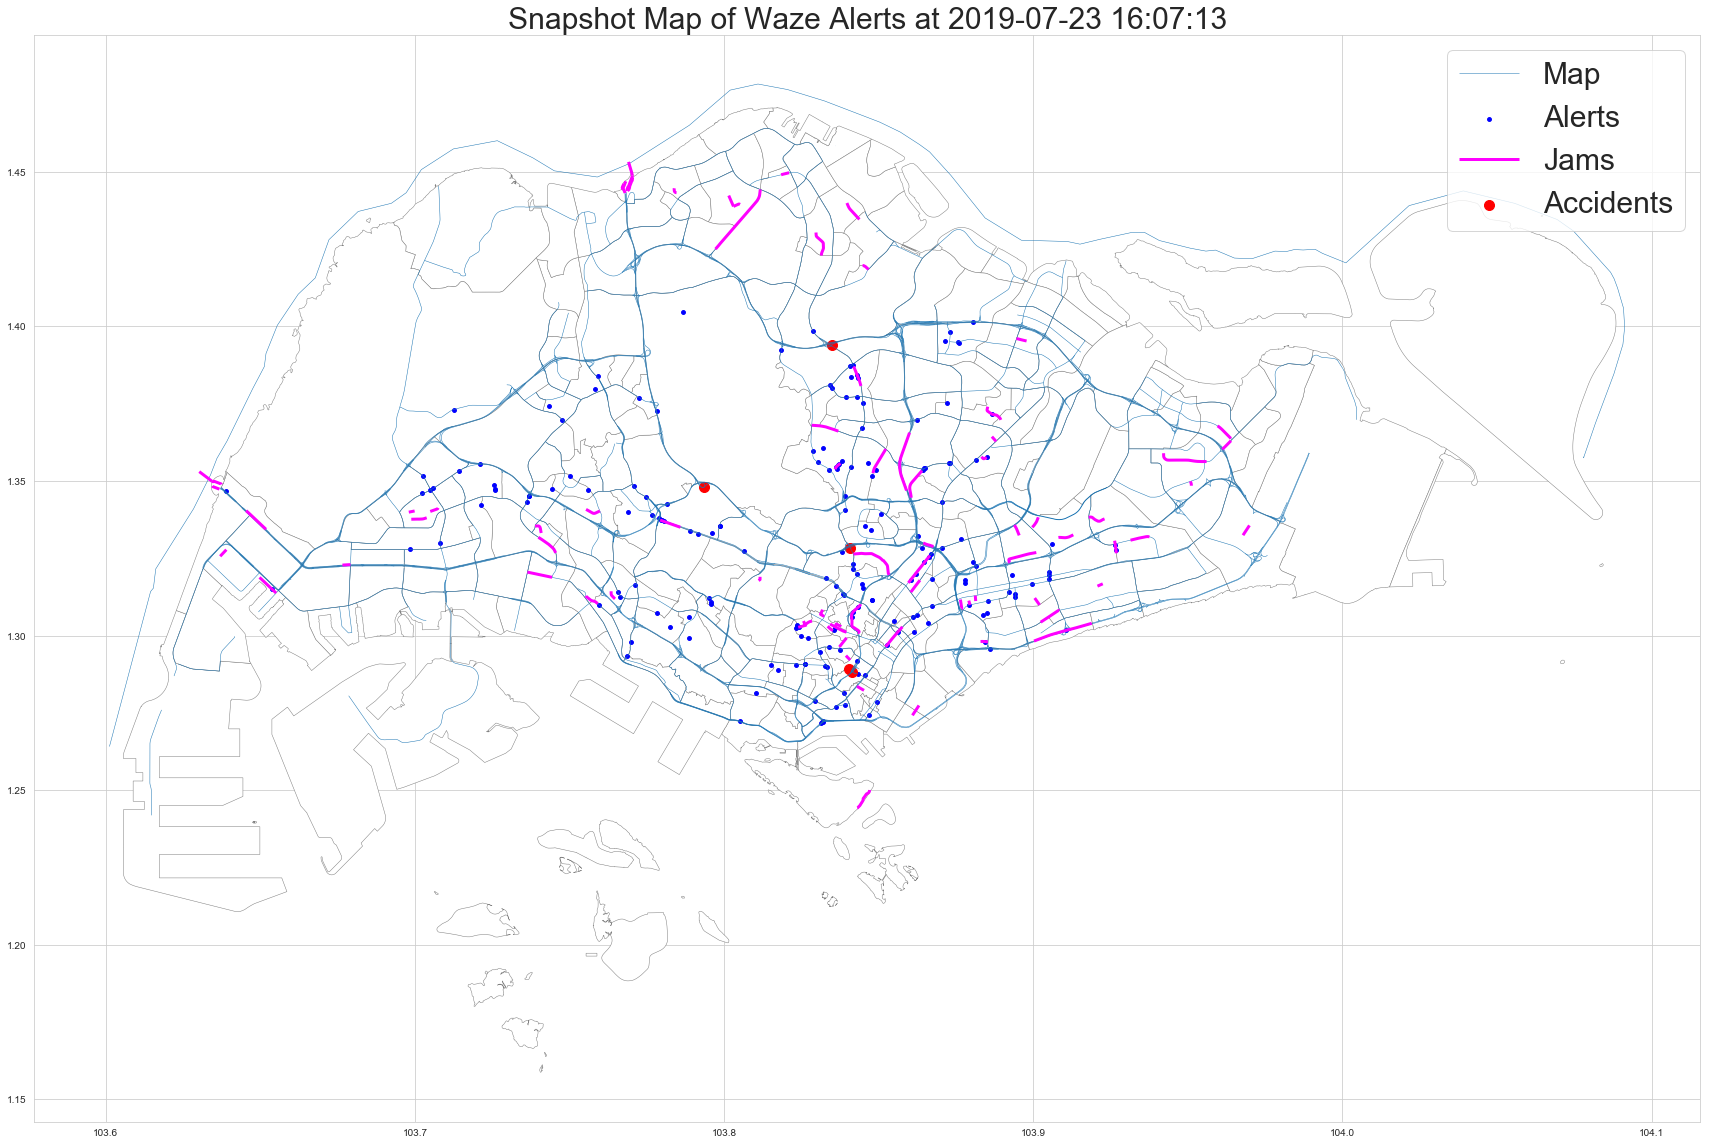

In [11]:
fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(111)

national_map_line_simplified.plot(ax=ax,linewidth=0.5) # Plot Singapore Map
subzonemap.plot(ax=ax,color='w', edgecolor='grey', linewidth=0.5) # Plot Singapore Map

alerts_gdf_SG.plot(ax=ax, color='b', markersize=15) # Plot Alert Locations
jams_gdf_SG.plot(ax=ax, color='magenta',linewidth=3.0) # Plot Alert Locations
alerts_gdf_SG_accident.plot(ax=ax, c='r', markersize=100) # Plot Alert Locations

ax.legend(["Map","Alerts","Jams","Accidents"], fontsize=30)

plt.title("Snapshot Map of Waze Alerts at "+datetime.datetime.now().strftime(format="%Y-%m-%d %H:%M:%S"), fontsize=30)
plt.savefig("Snapshot Map of Waze Alerts.png")
plt.show()